In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import os
import datetime as dt
from functools import wraps

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *

In [4]:
# Load data
model_type = "ols"
data_len = 8055 # 440, 660, 760, 1560, 8055
is_sent = False
week_day = 'daily'
predicted = "sp_close_lead1"

year_start = 2017
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

df_w = load_data(file_name=f"df_{week_day}_{data_len}.csv", file_path=WORK_DATA_DIR)
data_dict = load_data(file_name=f"dict_{week_day}_{data_len}.pkl", file_path=WORK_DATA_DIR)

Unknown columns found, columns were not casted
['termspread_lag1', 'termspread_lag2', 'termspread_lag3', 'termspread_lag4', 'termspread_lag5', 'termspread_lag6', 'termspread_lag7', 'termspread_lag8', 'termspread_lag9', 'termspread_lag10', 'termspread_lag11', 'termspread_lag12', 'termspread_lag13', 'termspread_lag14', 'termspread_lag15', 'ff_M_RF_lag1', 'ff_M_RF_lag2', 'ff_M_RF_lag3', 'ff_M_RF_lag4', 'ff_M_RF_lag5', 'ff_M_RF_lag6', 'ff_M_RF_lag7', 'ff_M_RF_lag8', 'ff_M_RF_lag9']
Exceptions were found
[KeyError('termspread_lag1'), KeyError('termspread_lag2'), KeyError('termspread_lag3'), KeyError('termspread_lag4'), KeyError('termspread_lag5'), KeyError('termspread_lag6'), KeyError('termspread_lag7'), KeyError('termspread_lag8'), KeyError('termspread_lag9'), KeyError('termspread_lag10'), KeyError('termspread_lag11'), KeyError('termspread_lag12'), KeyError('termspread_lag13'), KeyError('termspread_lag14'), KeyError('termspread_lag15'), KeyError('ff_M_RF_lag1'), KeyError('ff_M_RF_lag2'), K

In [5]:
if week_day == 'daily':
    assert is_sent is False, 'Treating non sentiment data'
    # training on X years
    df_w = df_w[(df_w["date"] >= dt.datetime(year=year_start, month=1, day=1).date())
             &(df_w["date"] <= dt.datetime(year=year_end, month=12, day=31).date())]
    print(f'data compromises {year_end - year_start + 1} years: {df_w.shape[0]} lines')
else:
    year_spread = 'yearsNA'
    df_w = cut_to_weekly_data(df_w, 'is_thu')

data compromises 5 years: 1167 lines


In [6]:
# update dict with model specific information
data_dict["model_features"].update(predicted=predicted)
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(data_len=data_len)
data_dict["model_metrics"].update(is_sent=is_sent)
data_dict["model_metrics"].update(week_day=week_day)
data_dict["model_metrics"].update(year_spread=year_spread)
data_dict["model_metrics"].update(model_name=f"{model_type}_{data_len}_{year_spread}_{data_dict['model_features']['predicted']}_sent{is_sent}")

# data selection

In [7]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    # 'vixo',
     # 'naaim_ind',
     # 'naaim_max',
     # 'naaim_q1',
     'ff_M_RF',
     'ff_SMB',
     'ff_HML',
     'ff_RMW',
     'ff_CMA',
     # 'termspread',
     # 'pc_ratio',
     # 'fears35',
     # 'aaii_Bullish',
     # 'aaii_Bearish',
     # 'aaii_Neutral',
     'sp_close',
     'sp_close_lag1',
     'sp_close_lag2',
     'sp_close_lag3',
     'sp_close_lag4',
     'sp_close_lag5',
     # 'sp_close_lag6',
     # 'sp_close_lag7',
     # 'sp_close_lag8',
     # 'sp_close_lag9',
     # 'sp_close_lag10',
     # 'sp_close_lag11',
     # 'sp_close_lag12',
     # 'sp_close_lag13',
     # 'sp_close_lag14',
     # 'sp_close_lag15'
]

categorical = [    
     # 'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

# TTS

In [8]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

In [9]:
df_train = df_ws.copy()

In [10]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=.3,
                                            add_const=False)

# Sesonality

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
## SEASONALITY DF
# create sub dataframe of X_train
X_train_sea = X_train.copy()

# insert datetime information
X_train_sea["date"] = pd.Series(X_train_sea.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x]).values
X_train_sea["weekday"] = is_day(X_train_sea.date)
X_train_sea["week"] = X_train_sea.date.apply(lambda x: apply_date_to_week(x))

# filter for complete weeks only
_ = X_train_sea.groupby("week").weekday.count() == 5
_ = _[_].index
X_train_sea = X_train_sea[X_train_sea["week"].isin(_)]

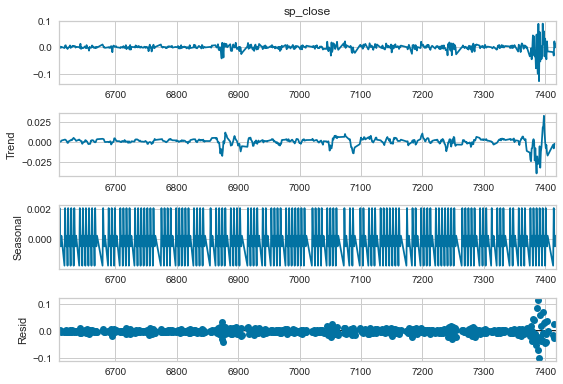

In [13]:
## SEASONALITY ANALYSIS
if week_day == "daily":
    # create statsmodel seasonality object
    sd = seasonal_decompose(X_train_sea.sp_close, period=5)
    sd.plot()
    plt.show()

    # get seasonality by weekday
    X_train_sea["seasonal"] = sd.seasonal
    data_dict["model_features"].update(weekday_seasonality= dict(zip(X_train_sea.groupby("weekday").seasonal.first().index, X_train_sea.groupby("weekday").seasonal.first().values)))

    # map sesonality to data
    _ = pd.Series(X_test.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_test["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    _ = pd.Series(X_train.index).apply(lambda x: data_dict["model_features"]["datetime_ind"][x])
    X_train["seasonal"] = is_day(_).map(data_dict["model_features"]["weekday_seasonality"]).values

    cols.append("seasonal")

# Corr

In [14]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Corr matrix

In [15]:
## ORTHOGONALISE
X_train = orthogonalise_vars(X_train, X="sp_close", y="ff_M_RF", show_fig=False)
# X_train = orthogonalise_vars(X_train, X="ff_SMB", y="ff_M_RF", show_fig=False)

,VIF,corr_sp_close_lead1
sp_close,1.293799,-0.280833
sp_close_lag5,1.141473,-0.227796
ff_HML,1.569095,-0.099300
sp_close_lag3,1.248290,-0.075956
seasonal,1.011788,-0.031595
ff_M_RF,1.156951,-0.006556
ff_RMW,1.050049,0.003852
sp_close_lag2,1.232484,0.009201
ff_CMA,1.433643,0.018593
ff_SMB,1.362549,0.052688


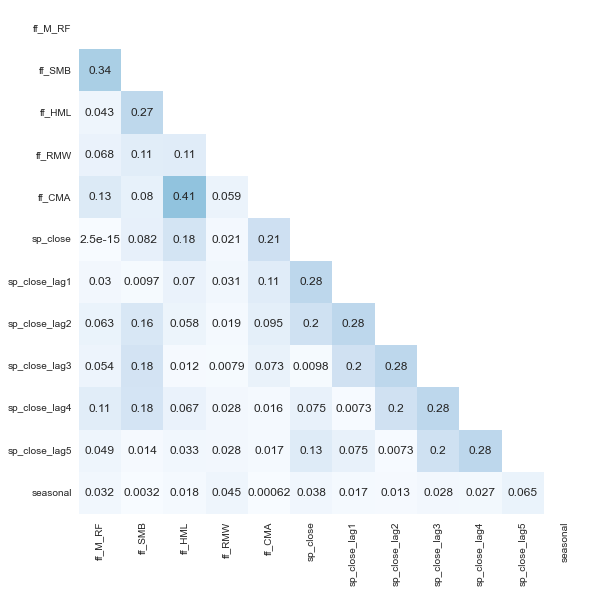

In [16]:
# only rely on correlation not vif
corr_heatmap(X_train, 
             cols,
             # size_factor=1,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

# Model

In [17]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [18]:
model = SKLearnWrap(sm.OLS, fit_intercept=True)
model_ = model.fit(X_train, y_train)

In [19]:
data_dict["model_metrics"].update(featuer_sig=model.results_.pvalues)
model.results_.pvalues < .05

ff_M_RF          False
ff_SMB            True
ff_HML            True
ff_RMW           False
ff_CMA           False
sp_close          True
sp_close_lag1     True
sp_close_lag2     True
sp_close_lag3    False
sp_close_lag4    False
sp_close_lag5     True
seasonal         False
intercept        False
dtype: bool

In [20]:
model.results_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         sp_close_lead1   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     12.47
Date:                Tue, 22 Mar 2022   Prob (F-statistic):           1.45e-23
Time:                        23:16:15   Log-Likelihood:                 2442.0
No. Observations:                 817   AIC:                            -4858.
Df Residuals:                     804   BIC:                            -4797.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
ff_M_RF          -0.0031      0.002     -1.578      0.115      -0.007       0.001
ff_SMB            0.0021      0.001      2.596      0.010       0.001       0.004
ff_HML           -0.0019      0.001     -2.467      0.014      -0.003      -0.000
ff_RMW            0.0014      0.001      1.157      0.248      -0.001       0.004
ff_CMA         1.675e-05      0.001      0.011      0.991      -0.003       0.003
sp_close         -0.2167      0.037     -5.881      0.000      -0.289      -0.144
sp_close_lag1     0.1715      0.036      4.778      0.000       0.101       0.242
sp_close_lag2     0.0859      0.036      2.384      0.017       0.015       0.157
sp_close_lag3    -0.0297      0.036     -0.820      0.413      -0.101       0.041
sp_close_lag4     0.0167      0.036      0.462      0.644      -0.054       0.088
sp_close_lag5    -0.1761      0.035     -5.072      0.000      -0.244      -0.108
seasonal         -0.1207      0.362     -0.334      0.739      -0.831       0.590
intercept         0.0003      0.000      0.686      0.493      -0.001       0.001
==============================================================================
Omnibus:                      365.708   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9212.869
Skew:                          -1.457   Prob(JB):                         0.00
Kurtosis:                      19.191   Cond. No.                         847.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
X_train

,ff_M_RF,ff_SMB,ff_HML,ff_RMW,ff_CMA,sp_close,sp_close_lag1,sp_close_lag2,sp_close_lag3,sp_close_lag4,sp_close_lag5,seasonal,intercept
6604,-0.000274,-0.10,0.06,-0.24,0.27,0.008451,-0.004648,-0.000293,-0.006146,0.001251,-0.001865,0.002045,1
6605,0.227049,0.96,-0.15,-0.52,-0.03,0.005706,0.008451,-0.004648,-0.000293,-0.006146,0.001251,-0.000138,1
6606,-0.142135,-1.02,-0.78,-0.24,-0.08,-0.000771,0.005706,0.008451,-0.004648,-0.000293,-0.006146,-0.000449,1
6607,-0.059152,-0.74,-0.30,-0.36,-0.30,0.003511,-0.000771,0.005706,0.008451,-0.004648,-0.000293,0.000248,1
6608,-0.031001,-0.34,-1.04,0.13,-0.52,-0.003555,0.003511,-0.000771,0.005706,0.008451,-0.004648,-0.001706,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7416,0.175328,1.25,0.57,0.52,-0.24,-0.000540,0.022671,-0.031155,-0.018043,0.026441,0.005800,-0.000449,1
7417,0.086591,0.24,-0.07,-0.19,0.15,0.013822,-0.000540,0.022671,-0.031155,-0.018043,0.026441,0.000248,1
7418,0.300161,2.15,2.72,-0.13,0.14,0.014607,0.013822,-0.000540,0.022671,-0.031155,-0.018043,-0.001706,1
7419,0.054692,1.72,2.82,1.35,0.73,-0.005256,0.014607,0.013822,-0.000540,0.022671,-0.031155,0.002045,1


In [118]:
class SKLearnWrap(BaseEstimator, RegressorMixin):

    def __init__(self,
                 model_class,
                 fit_intercept: bool = True):
        """
        SKLearn Wrapper for Statsmodels models
        :param model_class: Statsmodel.model e.g. sm.OLS
        :param fit_intercept:
        """
        self.model_class = model_class
        self.fit_intercept = fit_intercept

        self.model_ = None
        self.results_ = None
        pass

    def fit(self, X, y):
        """
        Fit trainig data to model
        :param X: X_train
        :param y: y_train
        :return: fitted model
        """
        if self.fit_intercept:
            X = add_constant(X, constant_value=1)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self

    def predict(self, X):
        """
        Model prediction
        :param X: X_test
        :return: predictions for X
        """
        if self.fit_intercept:
            X = add_constant(X, constant_value=1)
        return self.results_.predict(X)

In [1]:
class ExpandingPrediction:
    
    def __init__(self,
                 model_in,
                 X_train,
                 y_train,
                 X_test,
                 y_test):
        
        self.model_in = model_in
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        self.X_test = X_test.copy()
        self.y_test = y_test.copy()
        pass
    
    def predict(self,
                X_):
        self.y_pred = []
    
        ind_train = len(self.X_train)
        ind_test = len(self.X_test) - 1

        X = pd.concat([self.X_train,
                       self.X_test],
                      axis=0)
        y = pd.concat([self.y_train,
                       self.y_test],
                      axis=0)
        if 'intercept' in X.columns:
            X.drop('intercept', axis=1, inplace=True)

        for i in range(0, ind_test):
            model = model_in
            
            _trainx = X.iloc[0: ind_train + i]
            _trainy = y.iloc[0: ind_train + i]
            _testx = pd.DataFrame(X.iloc[ind_train + i  + 1 : ind_train + i  + 2])
            _testy = (y.iloc[ind_train + i  + 1: ind_train + i  + 2]).values[0]

            model.fit(_trainx, _trainy)
            pred = model.predict(_testx).values[0]

            self.y_pred.append([_testy, pred])

        return self.y_pred

In [119]:
def train_model_cv(model_in,
                   X_train,
                   y_train,
                   X_test,
                   y_test):
    
    resid = [["y_true", "y_pred"]]
    
    ind_train = len(X_train)
    ind_test = len(X_test) - 1
    
    X = pd.concat([X_train,
                   X_test],
                  axis=0)
    y = pd.concat([y_train,
                   y_test],
                  axis=0)
    X.drop('intercept', axis=1, inplace=True)
    # return X
    for i in range(0, ind_test):
        model = model_in
        
        _trainx = X.iloc[0: ind_train + i]
        _trainy = y.iloc[0: ind_train + i]
        _testx = pd.DataFrame(X.iloc[ind_train + i  + 1 : ind_train + i  + 2])
        _testy = (y.iloc[ind_train + i  + 1: ind_train + i  + 2]).values[0]
        
        model.fit(_trainx, _trainy)
        pred = model.predict(_testx).values[0]
        
        resid.append([_testy, pred])
    
    return resid

In [120]:
resid = train_model_cv(model,
                   X_train,
                   y_train,
                   X_test,
                   y_test)

In [122]:
x = pd.DataFrame(resid[1:], columns=resid[0])

In [124]:
x['resid'] = x.y_pred - x.y_true

In [128]:
from sklearn.metrics import mean_squared_error

In [130]:
mean_squared_error(x.y_true, x.y_pred, squared=False)

0.010502315709045806

# Out of sample eval

In [131]:
# benchmark: mittelwert prognose - das ist ein random walk mit drift

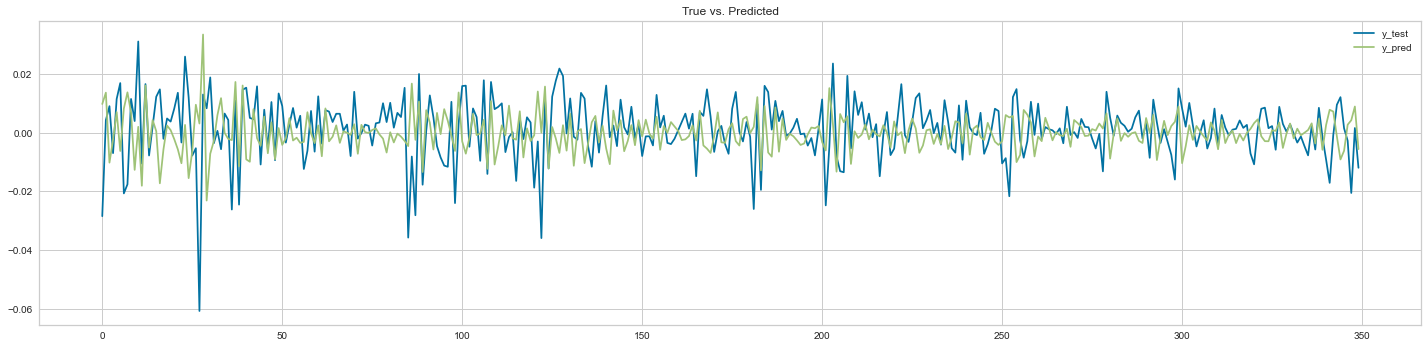

Validation Scores
root mean squared error: 0.0116391803
mean squared error: 0.0001354705
mean absolute error: 0.0085591163
R2: -0.2801508877


In [347]:
mval = ModelValidation(
            X_train=X_train,
            y_train=y_train,
            X_validate=X_test,
            y_validate=y_test,
            model=model,
            print_results=True)

fig_true_vs_fit = mval.get_model_performance()

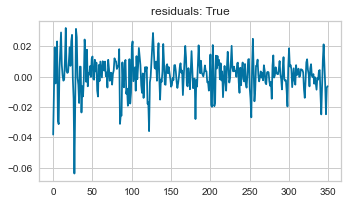

Stationarity Test Results
P-Values: 1.338392987468226e-27
Test-stats: -14.937359938758117
Time series is stationary: True




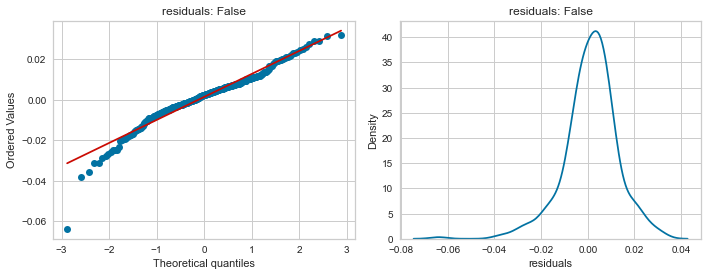

Normality Test Results
P-Values: 1.5506364422864676e-14
Test-stats: 63.5950516946702
Series is normally distributed: False


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


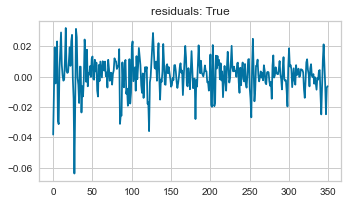

Test for Heteroskedasticity
Test p-value: 4.172162536992569e-09
Heteroskedasticity is present: True


TTest one sample for mean: 0
Test statistics: 2.052149785240688
Test pvalue: 0.04090066694203111
Population mean is equal to 0: True


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 1.343 < 2.5
First order autocorrlation is not present: : False


In [348]:
stat, norm, hetero, d_watson, zero_mean = mval.analyse_resids()

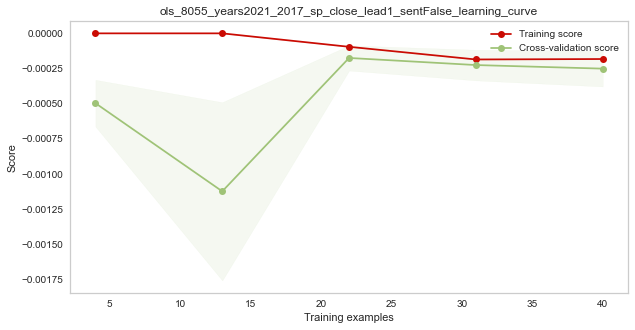

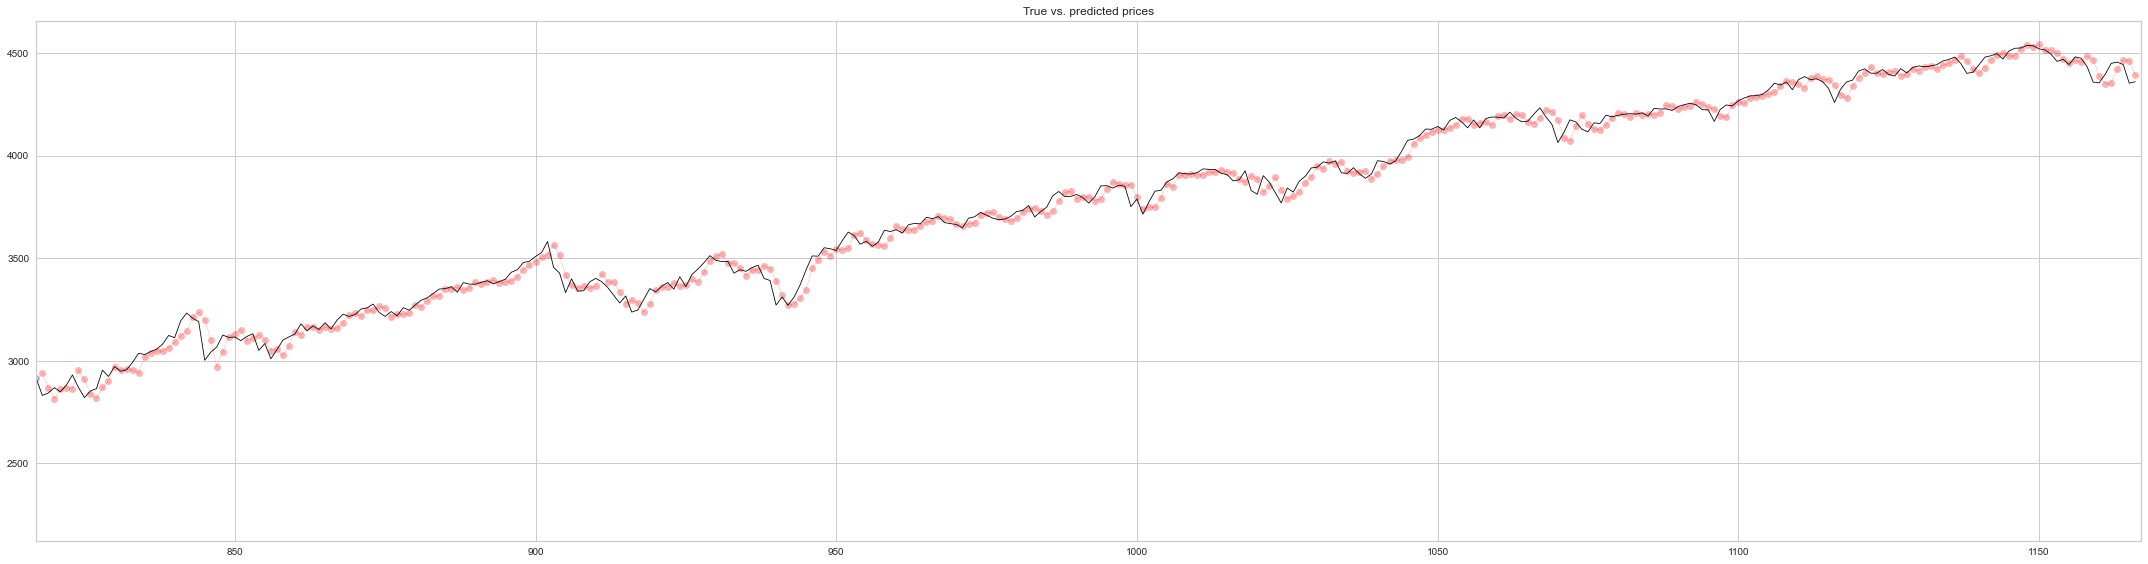

Validation Scores Test Data
mean squared error: 1690.1697531659
mean absolute error: 31.149812926
mean absolute error in %: 0.010246765907219908
r2: 0.992570072


In [349]:
fig_lcurve = mval.sm_learning_curve(f"{data_dict['model_metrics']['model_name']}_learning_curve", n_splits=10)
fig_prices = mval.plot_results_on_price_scale(df_w,
                                              df_train,
                                              sp_true_vals=data_dict["data"]["sp_true_vals"], show_pred_only=True)

In [350]:
# update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=d_watson)

# model performance
data_dict["model_metrics"].update(rmse=mval.rmse)
data_dict["model_metrics"].update(mse=mval.mse)
data_dict["model_metrics"].update(mae=mval.mae)
data_dict["model_metrics"].update(r2=mval.r2)
data_dict["model_metrics"].update(residuals=mval.resid_inv)

# Save model

In [81]:
save_model(model, df_train, data_dict, fig_true_vs_fit, fig_lcurve, fig_prices, OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-03-22_ols_8055_years2021_2017_sp_close_lead1_sentFalse"? (y/n)


 y
DIR EXISTS: DO YOU WANT TO REPLACE IT? (y/n) y
